In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime , timedelta
import joblib


2025-04-23 17:33:42.400745: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 17:33:42.666772: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 17:33:42.897360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745409823.104626   35550 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745409823.162276   35550 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745409823.587349   35550 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
train = pd.read_csv("/home/madhav/dev/PureDelhi/data/training_data.csv",
                 parse_dates=["Timestamp"])
                                                    
test = pd.read_csv("/home/madhav/dev/PureDelhi/data/test_data.csv",
                  parse_dates=["Timestamp"])

train = train.set_index("Timestamp")
test  = test.set_index("Timestamp")

In [3]:
scaler = MinMaxScaler()
train_scaled  = scaler.fit_transform(train[["PM2.5","PM10","NO2","CO","SO2"]])
test_scaled = scaler.transform(test[["PM2.5","PM10","NO2","CO","SO2"]])

In [5]:
joblib.dump(scaler, 'pollutant_scaler.pkl')

['pollutant_scaler.pkl']

In [4]:
train[["PM2.5","PM10","NO2","CO","SO2"]] = train_scaled
test[["PM2.5","PM10","NO2","CO","SO2"]]  = test_scaled

In [5]:
train.head()

,PM2.5,PM10,NO2,CO,SO2,sin_month,cos_month
Timestamp,,,,,,,
2017-01-01,0.258519,0.400693,0.518564,0.894772,0.384085,0.5,0.866025
2017-01-02,0.277147,0.421413,0.540440,0.923492,0.374765,0.5,0.866025
2017-01-03,0.282089,0.382883,0.568422,1.000000,0.389161,0.5,0.866025
2017-01-04,0.276936,0.353976,0.517242,0.832954,0.356007,0.5,0.866025
2017-01-05,0.273287,0.351397,0.584947,0.894652,0.425376,0.5,0.866025


In [6]:
model_pm25 = load_model("/home/madhav/dev/PureDelhi/models/LSTM(PM2.5).keras")
model_pm10 = load_model("/home/madhav/dev/PureDelhi/models/LSTM(PM10).keras")
model_no2 = load_model("/home/madhav/dev/PureDelhi/models/LSTM(NO2).keras")
model_so2 = load_model("/home/madhav/dev/PureDelhi/models/LSTM(SO2).keras")
model_co = load_model("/home/madhav/dev/PureDelhi/models/LSTM(CO).keras")

2025-04-22 23:57:24.486134: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
pollutants = ["PM2.5", "PM10", "NO2", "SO2", "CO"]
batches = {}

for pollutant in pollutants:
    batches[pollutant] = np.array([test[[pollutant, "sin_month", "cos_month"]][i:i+7].values for i in range(0, len(test)-7)])


In [8]:
predictions_pm25 = model_pm25.predict(batches["PM2.5"]).reshape(-1,1)
predictions_pm10 = model_pm10.predict(batches["PM10"]).reshape(-1,1)
predictions_no2 = model_no2.predict(batches["NO2"]).reshape(-1,1)
predictions_so2 = model_so2.predict(batches["SO2"]).reshape(-1,1)
predictions_co = model_co.predict(batches["CO"]).reshape(-1,1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step


In [9]:
predictions = np.concatenate([
    predictions_pm25,
    predictions_pm10,
    predictions_no2,
    predictions_co,
    predictions_so2,
    
], axis=1)  


In [10]:
actual_values = scaler.inverse_transform(test[7:][["PM2.5","PM10","NO2","CO","SO2"]])
predicted_values = scaler.inverse_transform(predictions)

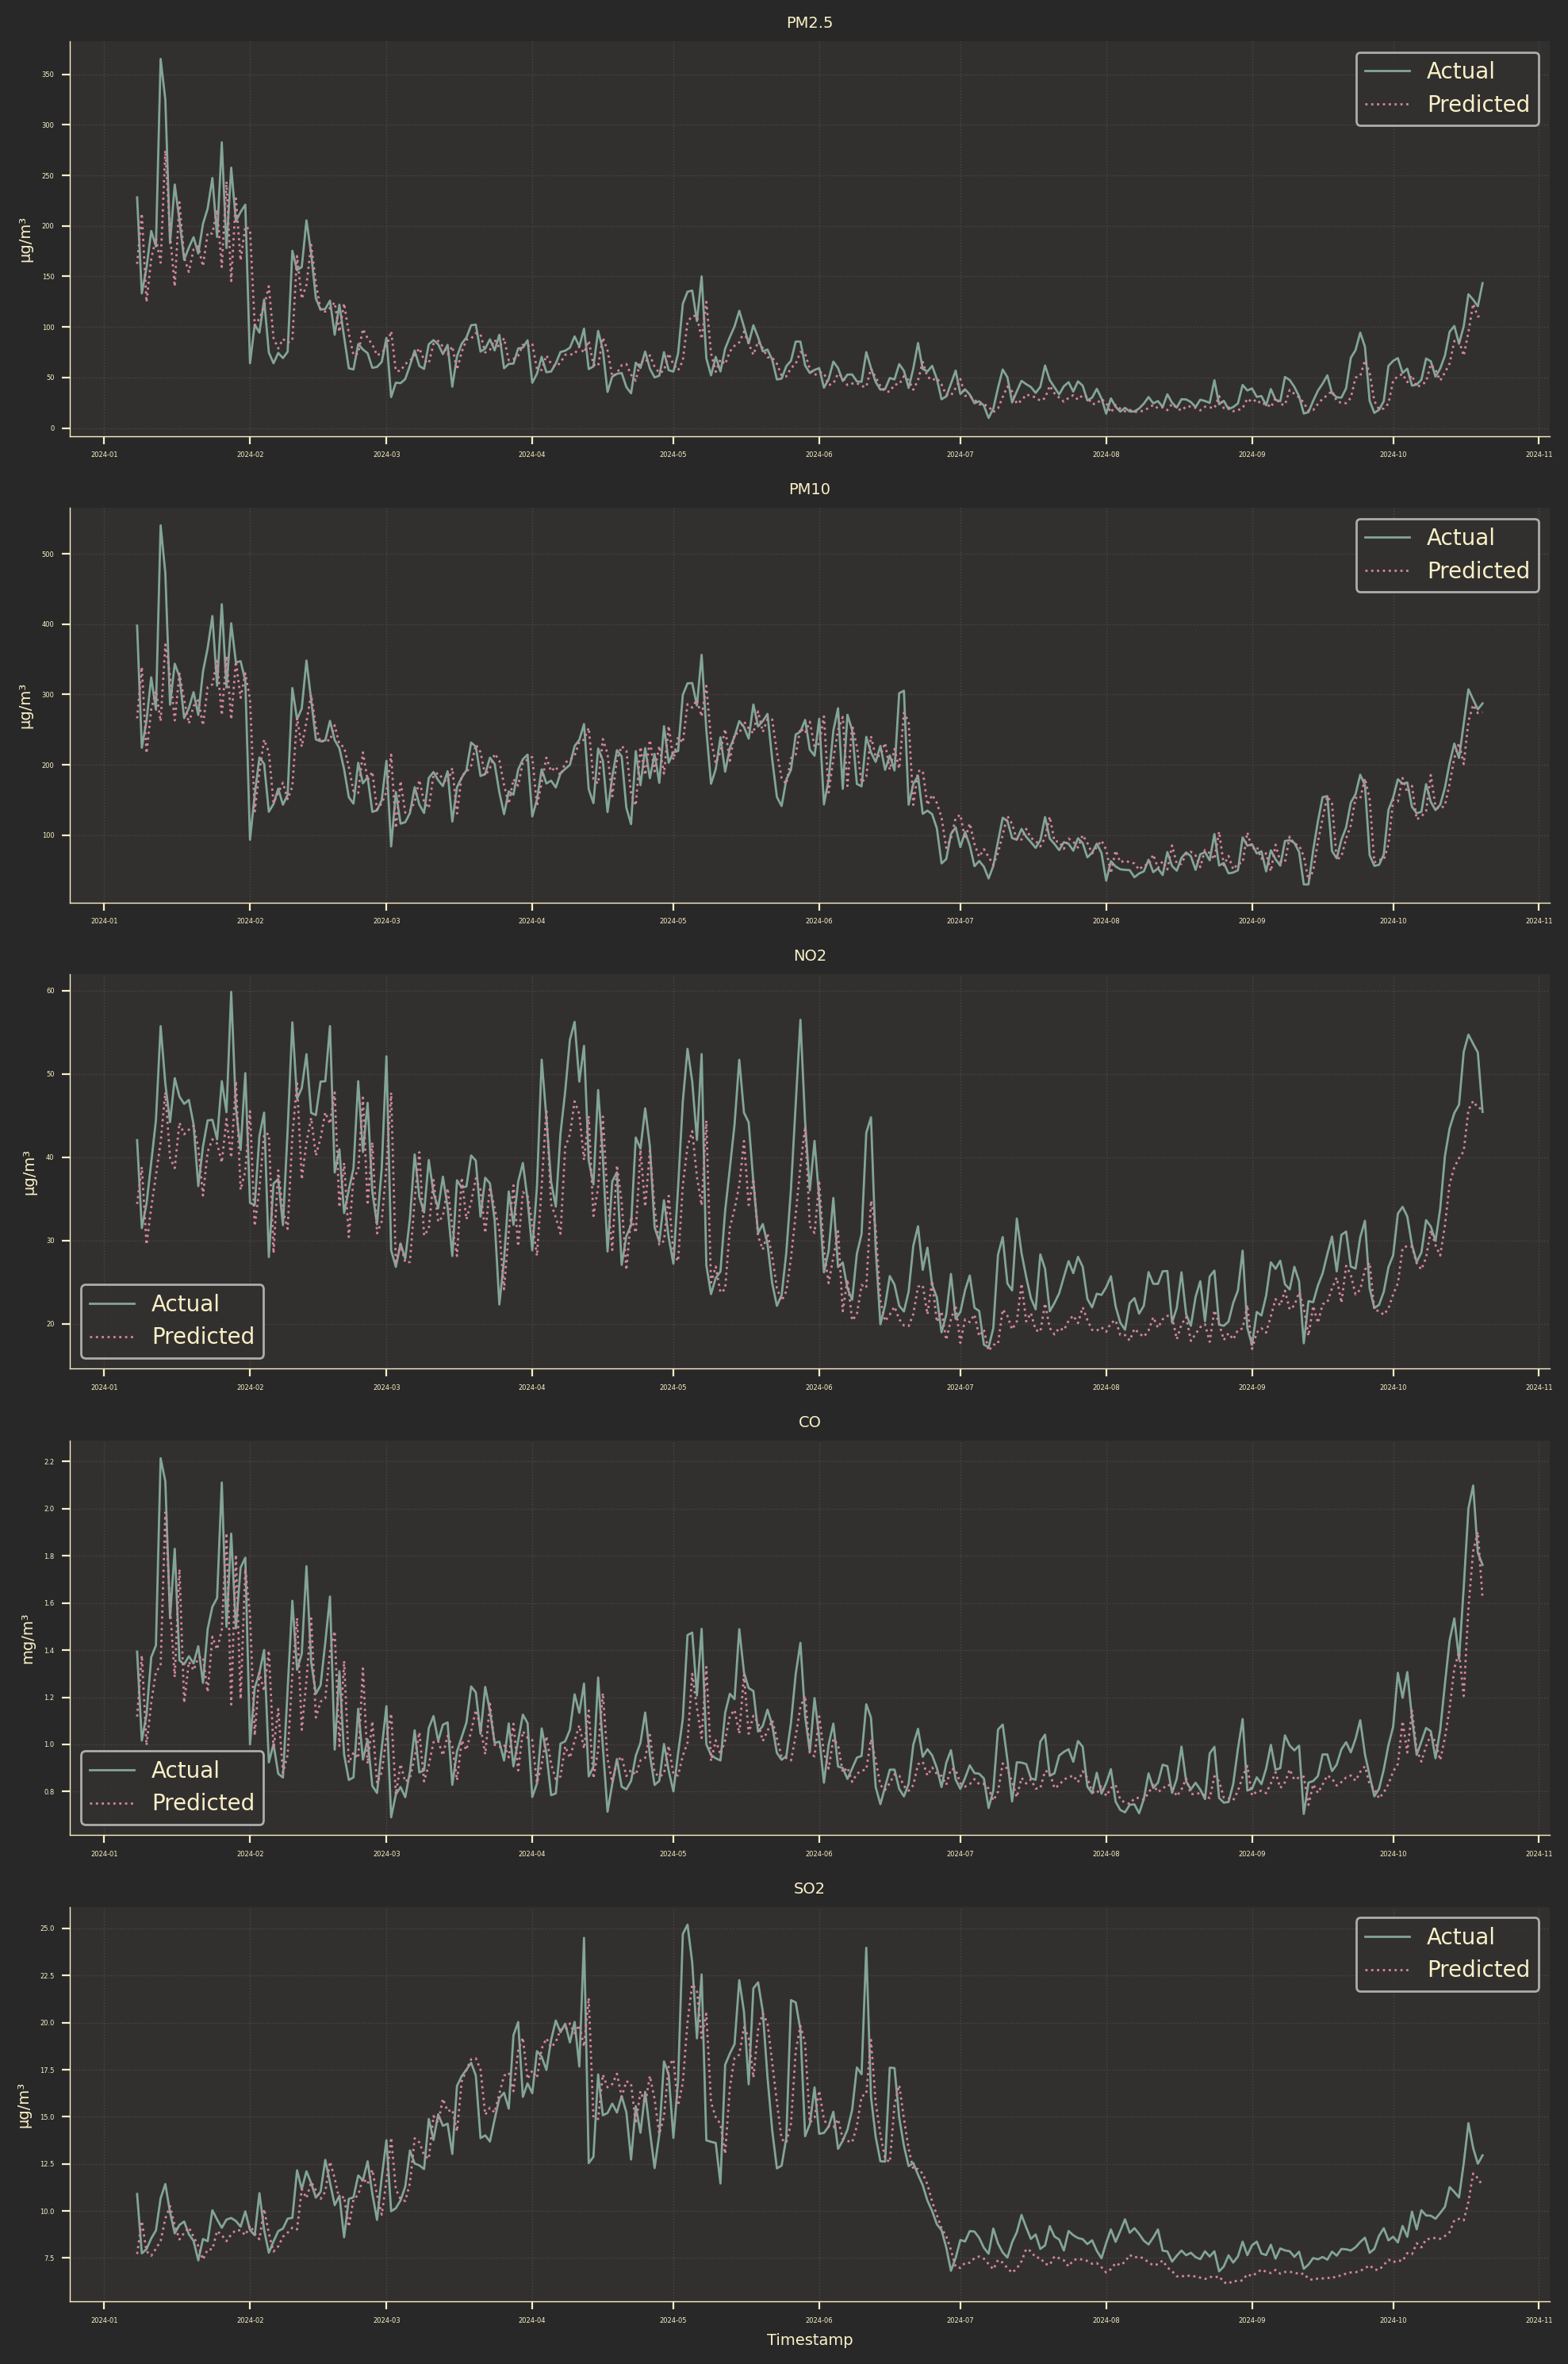

In [11]:
plt.style.use("gruvbox.mplstyle")
plt.figure(figsize=(10, 15))

# PM2.5
plt.subplot(5, 1, 1)
sns.lineplot(x=test[7:].index, y=actual_values[:, 0], color="C2", label="Actual")
sns.lineplot(x=test[7:].index, y=predicted_values[:, 0], color="C3", linestyle=":", label="Predicted")
plt.title("PM2.5")
plt.ylabel("µg/m³")
plt.xlabel("")
plt.legend()

# PM10
plt.subplot(5, 1, 2)
sns.lineplot(x=test[7:].index, y=actual_values[:, 1], color="C2", label="Actual")
sns.lineplot(x=test[7:].index, y=predicted_values[:, 1], color="C3", linestyle=":", label="Predicted")
plt.title("PM10")
plt.ylabel("µg/m³")
plt.xlabel("")
plt.legend()

# NO2
plt.subplot(5, 1, 3)
sns.lineplot(x=test[7:].index, y=actual_values[:, 2], color="C2", label="Actual")
sns.lineplot(x=test[7:].index, y=predicted_values[:, 2], color="C3", linestyle=":", label="Predicted")
plt.title("NO2")
plt.ylabel("µg/m³")
plt.xlabel("")
plt.legend()

# CO
plt.subplot(5, 1, 4)
sns.lineplot(x=test[7:].index, y=actual_values[:, 3], color="C2", label="Actual")
sns.lineplot(x=test[7:].index, y=predicted_values[:, 3], color="C3", linestyle=":", label="Predicted")
plt.title("CO")
plt.ylabel("mg/m³")
plt.xlabel("")
plt.legend()

# SO2
plt.subplot(5, 1, 5)
sns.lineplot(x=test[7:].index, y=actual_values[:, 4], color="C2", label="Actual")
sns.lineplot(x=test[7:].index, y=predicted_values[:, 4], color="C3", linestyle=":", label="Predicted")
plt.title("SO2")
plt.ylabel("µg/m³")
plt.xlabel("Timestamp")
plt.legend()

plt.tight_layout()


In [12]:
batches_train = {}
batches_test = {}

for pollutant in pollutants:
    batches_train[pollutant] = np.array([train[[pollutant, "sin_month", "cos_month"]][i:i+7].values for i in range(0, len(train)-7)])
    batches_test[pollutant] = np.array([test[[pollutant, "sin_month", "cos_month"]][i:i+7].values for i in range(0, len(test)-7)])
    


In [13]:
print("TRAIN DATA PREDICTION")
lstm_train_pm25 = model_pm25.predict(batches_train["PM2.5"]).reshape(-1,1)
lstm_train_pm10 = model_pm10.predict(batches_train["PM10"]).reshape(-1,1)
lstm_train_no2 = model_no2.predict(batches_train["NO2"]).reshape(-1,1)
lstm_train_so2 = model_so2.predict(batches_train["SO2"]).reshape(-1,1)
lstm_train_co = model_co.predict(batches_train["CO"]).reshape(-1,1)

print("\nTEST DATA PREDICTION")
lstm_test_pm25 = model_pm25.predict(batches_test["PM2.5"]).reshape(-1,1)
lstm_test_pm10 = model_pm10.predict(batches_test["PM10"]).reshape(-1,1)
lstm_test_no2 = model_no2.predict(batches_test["NO2"]).reshape(-1,1)
lstm_test_so2 = model_so2.predict(batches_test["SO2"]).reshape(-1,1)
lstm_test_co = model_co.predict(batches_test["CO"]).reshape(-1,1)

TRAIN DATA PREDICTION
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

TEST DATA PREDICTION
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
